# ===> Model Prediction

# Import Libraries

In [13]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier

# Read data

In [14]:
df_eda = pd.read_csv("/kaggle/input/space-y-dataset/dataset_part_2.csv")

In [15]:
# landing_outcomes = df_eda ['Outcome'].value_counts()
# bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
# for i,outcome in enumerate(landing_outcomes.keys()):
#     print(i,outcome)
# # Creating landing outcome lablel from outcome column
# # landing_class = 0 if bad_outcome
# landing_class = df_eda['Outcome'].apply(lambda x: 0 if x in bad_outcomes else 1)
# # landing_class = 1 otherwise
# landing_class = df_eda['Outcome'].apply(lambda x: 1 if x not in bad_outcomes else 0)
# df_eda['Class']=landing_class
# display(df_eda.head())
# #Calculate mean/success rate over all
# print("Success rate "+ str(df_eda["Class"].mean()))
# df_eda['Year'] = pd.to_datetime(df_eda['Date']).dt.year
# annual_success_rate = df_eda.groupby('Year')['Class'].mean().reset_index()

In [16]:
# df_eda.to_csv('/kaggle/working/dataset_part_2.csv', index=False)

# Selecting relevant features from the dataframe

In [17]:
features = df_eda[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 
                'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 
                'ReusedCount', 'Serial','Class']]

# Convert one-hot encoded features to float

In [18]:
features =df_eda[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 
                'Flights', 'GridFins', 'Reused', 'Legs', 
                'LandingPad', 'Block', 'ReusedCount', 'Serial','Class']]

In [19]:
if 'Date' in features.columns:
    features.drop(columns=['Date'], inplace=True)

In [20]:
features_one_hot = pd.get_dummies(features, columns=['LaunchSite', 'Orbit', 'LandingPad', 'Serial'])
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Class,LaunchSite_CCSFS SLC 40,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,6,6123.547647,1,False,False,False,1.0,0,0,True,...,False,False,False,False,False,False,False,False,False,False
1,8,525.000000,1,False,False,False,1.0,0,0,True,...,False,False,False,False,False,False,False,False,False,False
2,10,677.000000,1,False,False,False,1.0,0,0,True,...,False,False,False,False,False,False,False,False,False,False
3,11,500.000000,1,False,False,False,1.0,0,0,False,...,False,False,False,False,False,False,False,False,False,False
4,12,3170.000000,1,False,False,False,1.0,0,0,True,...,False,False,False,False,False,False,False,False,False,False


In [21]:
features_one_hot = features_one_hot.astype('float64')

# Save one-hot encoded features to CSV

In [22]:
features_one_hot.to_csv('dataset_part_3.csv', index=False)

In [23]:
features_one_hot.to_csv('/kaggle/working/dataset_part_3.csv', index=False)

# Load datasets

In [24]:
data = pd.read_csv('/kaggle/input/space-y-dataset/dataset_part_2.csv')
X = pd.read_csv('/kaggle/working/dataset_part_3.csv')

In [25]:
print(df_eda.columns)

Index(['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit',
       'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'Reused', 'Legs',
       'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Longitude', 'Latitude',
       'Class', 'Year'],
      dtype='object')


In [26]:
Y = df_eda['Class'].to_numpy()

# Standardize the features

In [27]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets, maintaining class distribution

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=2, stratify=Y)

In [29]:
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Display class distribution in training and test sets

In [30]:
print(pd.Series(Y_train).value_counts())
print(pd.Series(Y_test).value_counts())

1    48
0    24
Name: count, dtype: int64
1    12
0     6
Name: count, dtype: int64


# Setting up cross-validation strategy

In [31]:
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

# Hyperparameters for different models

In [32]:
params = {
    'Decision Tree': {
        'classifier': DecisionTreeClassifier(),
        'param_grid': {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [2 * n for n in range(1, 10)],
            'max_features': ['sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'class_weight': [None, 'balanced'],
            'ccp_alpha': np.linspace(0, 0.035, 10)
        }
    },
    'K-Nearest Neighbors': {
        'classifier': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': list(range(1, 11)),
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1, 2],
            'leaf_size': list(range(20, 41, 5)),
            'n_jobs': [-1]
        }
    },
    'Logistic Regression': {
        'classifier': LogisticRegression(),
        'param_grid': {
            "C": [0.01, 0.1, 1],
            "penalty": ['l2'],
            "solver": ['lbfgs'],
            "fit_intercept": [True, False],
            "class_weight": [None, 'balanced'],
            "max_iter": [100, 200, 500],
            "tol": [1e-4, 1e-3, 1e-2],
            "multi_class": ['ovr', 'multinomial']
        }
    },
    'Support Vector Machine': {
        'classifier': SVC(),
        'param_grid': {
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': np.logspace(-3, 3, 5),
            'gamma': np.logspace(-3, 3, 5),
            'degree': [2, 3, 4],
            'coef0': np.linspace(-1, 1, 5),
            'shrinking': [True, False],
            'probability': [True, False]
        }
    }
}

# Lists to collect results

In [33]:
model_names = []
train_accuracies = []
test_accuracies = []
best_params_list = []

# Iterate over each model to perform hyperparameter tuning

In [34]:
for model_name, model_info in params.items():
    model = model_info['classifier']
    grid_search = GridSearchCV(model, model_info['param_grid'], cv=stratified_kfold)
    
    grid_search.fit(X_train, Y_train)
    
    model_names.append(model_name)
    train_accuracies.append(grid_search.best_score_)
    test_accuracies.append(grid_search.score(X_test, Y_test))
    best_params_list.append(grid_search.best_params_)

# Save best hyperparameters to a JSON file

In [35]:
best_params = {name: params for name, params in zip(model_names, best_params_list)}
with open('/kaggle/working/best_params.json', 'w') as f:
    json.dump(best_params, f)

# Plot confusion matrices for each model

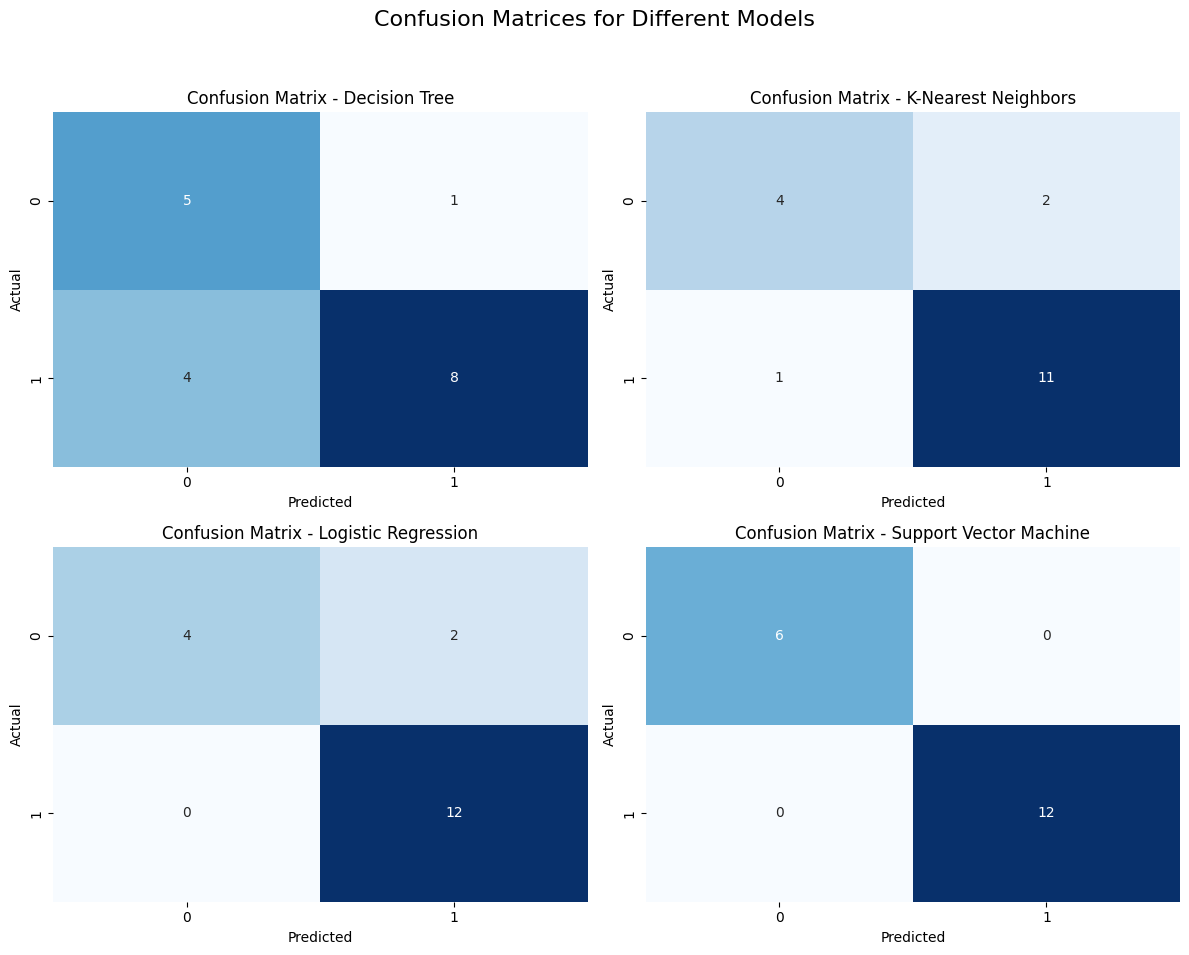

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Confusion Matrices for Different Models', fontsize=16)

for i, model_name in enumerate(model_names):
    ax = axes.flatten()[i]
    model = params[model_name]['classifier'].set_params(**best_params_list[i])
    model.fit(X_train, Y_train)
    
    predictions = model.predict(X_test)
    cm = confusion_matrix(Y_test, predictions)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix - {model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Compile results into a DataFrame for analysis

In [37]:
results_df = pd.DataFrame({
    'Model': model_names,
    'Training Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Best Params': best_params_list
})

# Identify and print the best-performing model

In [38]:
best_model_info = results_df.loc[results_df['Training Accuracy'].idxmax()]
print(f"Best model: {best_model_info['Model']} with accuracy: {best_model_info['Training Accuracy']:.2f}")
print(f"Best hyperparameters: {best_model_info['Best Params']}")

Best model: Decision Tree with accuracy: 0.99
Best hyperparameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


# Visualize model accuracies

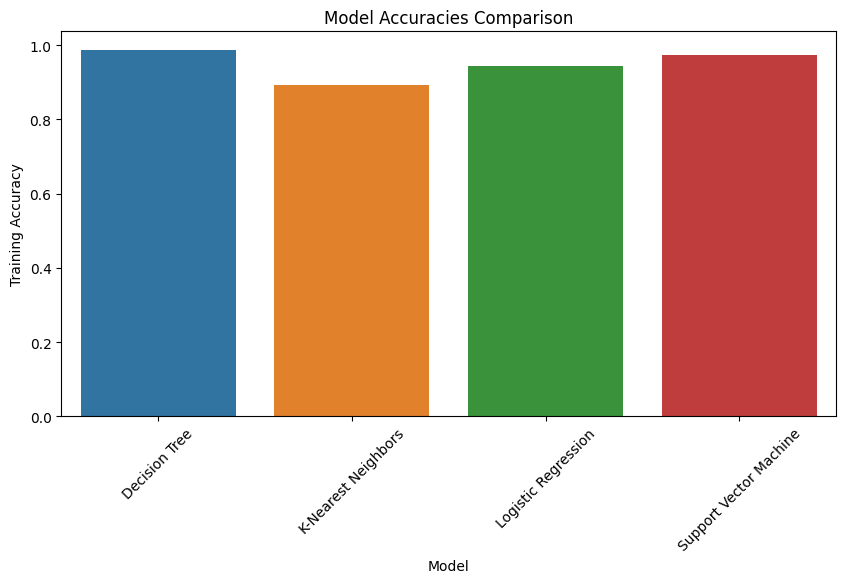

In [39]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='Training Accuracy', data=results_df)
plt.title('Model Accuracies Comparison')
plt.xlabel('Model')
plt.ylabel('Training Accuracy')
plt.xticks(rotation=45)
plt.show()

# Final model training with best hyperparameters

In [40]:
final_model = DecisionTreeClassifier(
    ccp_alpha=0.0194,
    class_weight=None,
    criterion='gini',
    max_depth=16,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=10,
    splitter='random'
)

# Train final model on the full training data

In [41]:
final_model.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0194, max_depth=16, max_features='sqrt',
                       min_samples_split=10, splitter='random')

# Evaluate final model on test set

In [42]:
final_test_accuracy = final_model.score(X_test, Y_test)
print(f"Final Model Test Accuracy: {final_test_accuracy * 100:.2f}%")

Final Model Test Accuracy: 94.44%
